# Imports

In [1]:
import numpy as np
from numba import jit,cuda
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32
from matplotlib import pyplot as plt
import math,time
import scipy.ndimage.filters
from threading import Thread,Lock
from ipywidgets import Image, HBox
import ipywidgets as widgets
from ipycanvas import Canvas
import io


# Thread Management

In [2]:
class Cleanup():
    """The purpose of this is to keep track of all the threads I run, and terminate
    them with reset or hard_reset."""
    def __init__(self):
        self.threads = []
    def add(self,*threads):
        """Keep a list of active threads"""
        for thread in threads:
            self.threads.append(thread)
    def reset(self):
        """Threads with a while loop terminate according to a variable called isalive.
        This will terminate all running threads, but raise an exception with threads 
        that have not started yet"""
        for t in self.threads:
            t.isalive=False
            t.join()
        self.threads=[]
    def hard_reset(self):
        """This makes sure all threads have been started then terminates them."""
        for a in self.threads:
            try:
                a.start()
            except:
                pass
        self.reset()
cleaner = Cleanup()

# Simple Ising update
This is the same update as seen on [The website](http://l-2-g.github.io/GPUIsing)

In [3]:
@cuda.jit
def fast_ising(grid,JB,mew,parity,rng_states,size):
    """Updates 1/4 of the grid by stochastically choosing points
    on a checkerboard grid and updating with boltzmann probability"""
    #find grid location
    i,j=cuda.grid(2)
    #get your first random number
    n = xoroshiro128p_uniform_float32(rng_states, i*size+j)
    #parity is 0 or 1, and tells you which half of the checkerboard to update
    #Instead of updating the entire checkerboard,  each position
    #is updated with probability 0.5
    if ((i+j)%2==parity and n < 0.5 and i<size and j<size):
        #sum the values of the nearest neighbors
        sum_=grid[i-1][j]+grid[i+1-size][j]+grid[i][j-1]+grid[i][j+1-size]
        #its grid*2-1 because I am using zero for spin down and 1 for spin up
        delta = 2.0 * (grid[i][j]*2-1)*(2*sum_-4+mew)
        #get our second random number
        n = xoroshiro128p_uniform_float32(rng_states, i*size+j)
        #update the cell according to the boltzmann distribution
        if (delta < 0 or 1-n < math.exp(-JB*delta)):
            grid[i][j]=1-grid[i][j]

# Simple SOR Poisson Solver
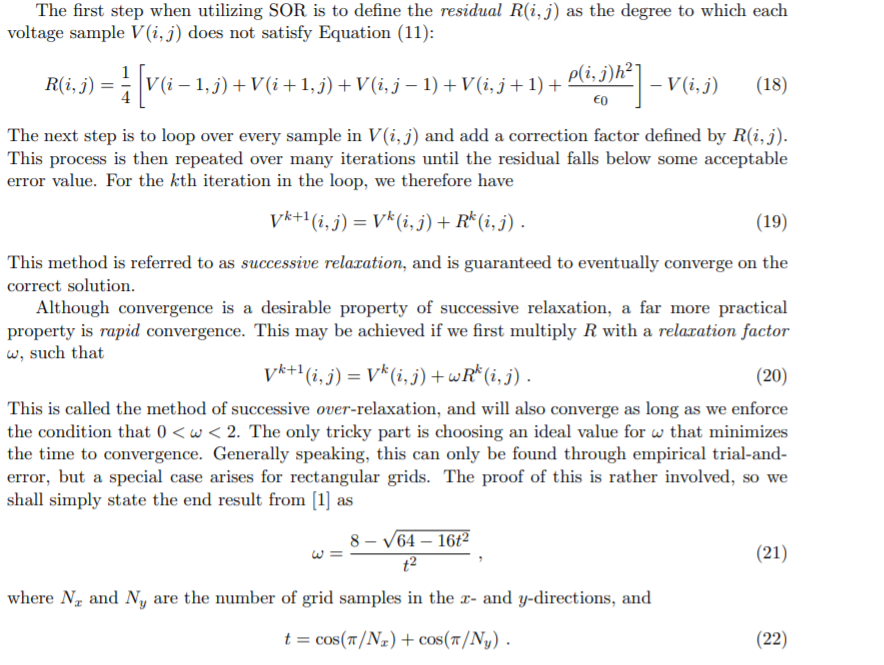
The cpu function follows these steps exactly, but the gpu updates the grid in two steps by splitting
the grid into two checkerboards.

In [4]:
@jit(nopython=True)
def update(V,p,mutable,w,h=1):
    """Simple Poisson solver to run on the cpu"""
    #assume p is predivided by epsilon
    #V2=V.copy()
    sx,sy=V.shape
    rmax=0
    for i in range(sx):
        for j in range(sy):
            R = (h**2*p[i][j]+V[i-1][j]+V[i+1-sx][j]+V[i][j-1]+V[i][j+1-sy])/4-V[i][j]
            if mutable[i][j]:
                V[i][j]+=w*R
                if abs(R)>rmax:
                    rmax=abs(R)
    return V,rmax

            
@cuda.jit
def updategpu(V,p,mutable,w,h,parity):
    """Simple Poisson solver to run on the gpu"""
    #assume p is predivided by epsilon
    i, j = cuda.grid(2)
    sx,sy=V.shape    
    if mutable[i][j] and ((i+j)%2==parity) and i<sx and j<sy:
        R = (h**2*p[i][j]+V[i-1][j]+V[i+1-sx][j]+V[i][j-1]+V[i][j+1-sy])/4.0-V[i][j]
        V[i][j]+=w*R
        
@cuda.jit
def thread_unsafe_err(V,p,mutable,w,h,arr_answer):
    """This just gives the max error in the SOR update. It is also thread safe now"""
    #assume p is predivided by epsilon
    i, j = cuda.grid(2)
    sx,sy=V.shape    
    if mutable[i][j] and i<sx and j<sy:
        R = (h**2*p[i][j]+V[i-1][j]+V[i+1-sx][j]+V[i][j-1]+V[i][j+1-sy])/4.0-V[i][j]
        aR=abs(R)
        cuda.atomic.max(arr_answer,0,aR)

# Slightly More Complex Solver
The code for this is only written for the GPU
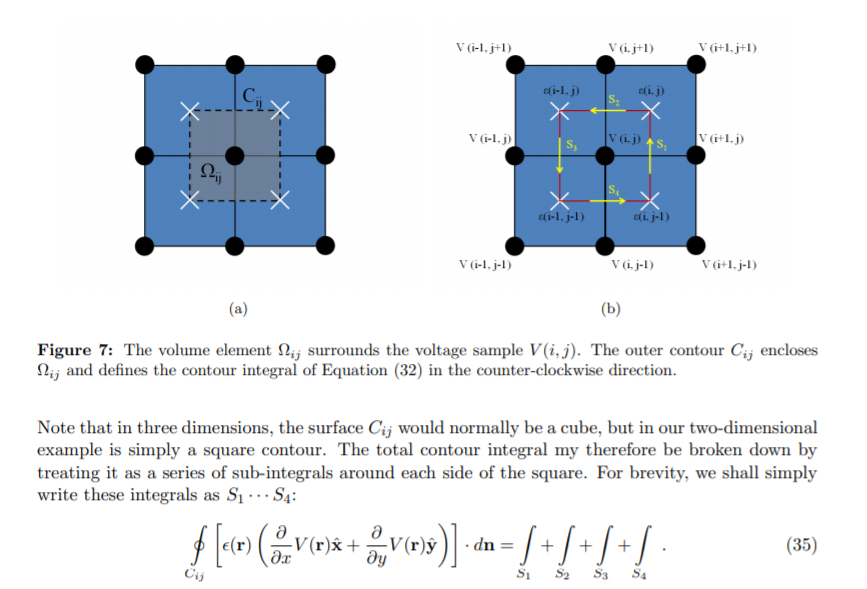



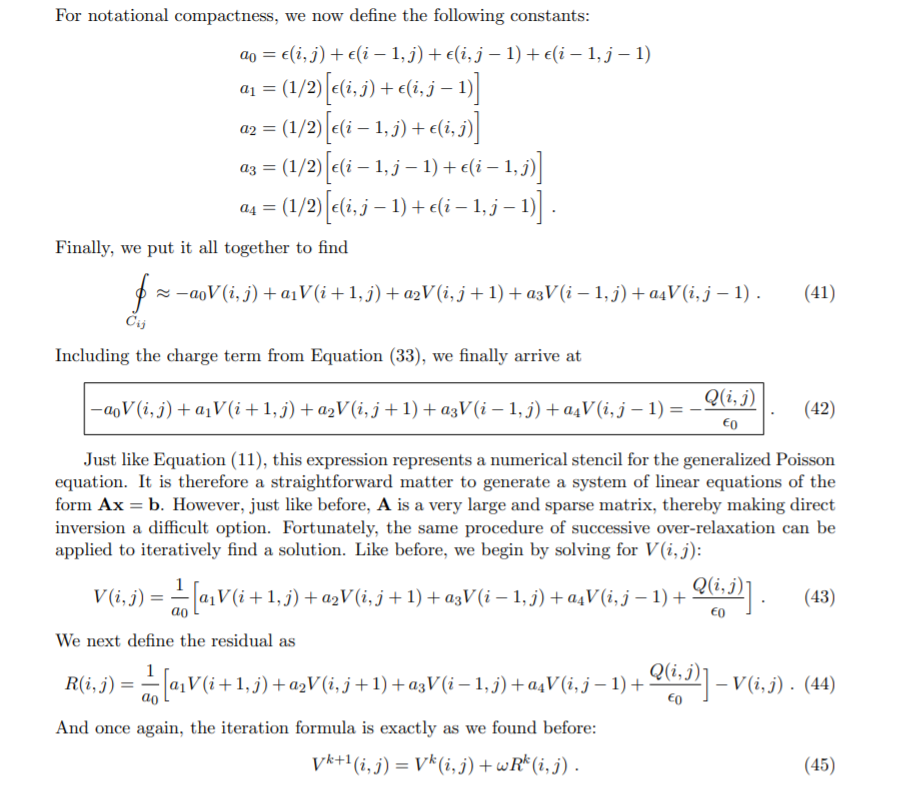


In [5]:

@cuda.jit
def generalpoisson(V,p,eps,mutable,w,h,parity):
    #assume p is predivided by epsilon_0
    #eps gives the multiplier by epsilon_0 of the permitivity and is staggered wrto V and p
    i, j = cuda.grid(2)
    sx,sy=V.shape
    if mutable[i][j] and ((i+j)%2==parity) and i<sx and j<sy:
        #some nice constants used in the solution
        #They have something to do with making a square integral around the grid point for V,
        #passing by four epsilon values
        a0=eps[i][j]+eps[i-1][j]+eps[i][j-1]+eps[i-1][j-1]
        a1=(eps[i][j]+eps[i][j-1])/2.0
        a2=(eps[i-1][j]+eps[i][j])/2.0
        a3=(eps[i-1][j-1]+eps[i-1][j])/2.0
        a4=(eps[i][j-1]+eps[i-1][j-1])/2.0
        R = (h**2*p[i][j]+a1*V[i+1-sx][j]+a2*V[i][j+1-sy]+a3*V[i-1][j]+a4*V[i][j-1])/a0-V[i][j]
        V[i][j]+=w*R        

@cuda.jit
def generalpoisson_err(V,p,eps,mutable,w,h,arr_answer):
    """Gives Error in the Generalized poisson update"""
    i, j = cuda.grid(2)
    sx,sy=V.shape    
    if mutable[i][j] and i<sx and j<sy:
        a0=eps[i][j]+eps[i-1][j]+eps[i][j-1]+eps[i-1][j-1]
        a1=(eps[i][j]+eps[i][j-1])/2.0
        a2=(eps[i-1][j]+eps[i][j])/2.0
        a3=(eps[i-1][j-1]+eps[i-1][j])/2.0
        a4=(eps[i][j-1]+eps[i-1][j-1])/2.0
        R = (h**2*p[i][j]+a1*V[i+1-sx][j]+a2*V[i][j+1-sy]+a3*V[i-1][j]+a4*V[i][j-1])/a0-V[i][j]
        aR=abs(R)
        cuda.atomic.max(arr_answer,0,aR)
        

@cuda.jit
def setzero(ans):
    i=cuda.grid(1)
    if i<ans.size:
        ans[i]=0
        
        


# Ising Setup and Rendering

In [6]:

class Ising(Thread):
    def __init__(self, N):
        self.N=N
        self.grid=np.asarray(np.random.random([N,N])>0.5,dtype=np.float32)
        self.threadsperblock = (16, 16)#should end up a multiple of 32 I think
        blockspergrid_x = int(np.ceil(self.grid.shape[0] / self.threadsperblock[0]))
        blockspergrid_y = int(np.ceil(self.grid.shape[1] / self.threadsperblock[1]))
        self.blockspergrid = (blockspergrid_x, blockspergrid_y)
        self.isalive=True
        self.rng_states = create_xoroshiro128p_states(self.grid.size, seed=1)
        self.grid_global_mem = cuda.to_device(self.grid)
        self.JB=5
        self.mew=0
        self.rspeed=100
        super(Ising, self).__init__()
    def run(self):
        while self.isalive:
            #parity=np.random.random()>0.5
            for x in range(self.rspeed):
                fast_ising[self.blockspergrid, self.threadsperblock](self.grid_global_mem,self.JB,self.mew,0,self.rng_states,self.N)
                fast_ising[self.blockspergrid, self.threadsperblock](self.grid_global_mem,self.JB,self.mew,1,self.rng_states,self.N)
            if self.rspeed<100:
                time.sleep(0.05)

class Render(Thread):
    def __init__(self, globalmem, canvas):
        self.grid_global_mem = globalmem
        self.canvas = canvas
        self.isalive=True
        super(Render, self).__init__()
    def run(self):
        while self.isalive:
            gridf= self.grid_global_mem.copy_to_host()
            
            blue_channel = (1-gridf)*255
            red_channel = gridf*255
            green_channel = np.zeros_like(gridf)
            image_data = np.stack((blue_channel, blue_channel, blue_channel), axis=2)
            self.canvas.put_image_data(image_data, 0, 0)
            time.sleep(0.01)

# This quiver function I wrote Proves I have big brain
Try to make sense of it at own risk

In [7]:
@cuda.jit
def jetRGBArrow(data,image,min_,max_,E):
    """Turns a [0,1] single channel image into an RGB one using the jet colormap, then
    plots vectors from a two channel image representing vector data
    Parameters:
        data:  (Input)  2D Array representing a single channel image
        image: (Output) 3D Array representing RGB values
        min_:  (Input)  Specifies the minimum value in data
        max_:  (Input)  Specifies the maximum value in data
        V:     (Input)  3D Array specifying Velocity in x-y
    """
    i,j=cuda.grid(2)

    #Recreating the jet colormap which specifies RGB values
    #for numbers in [0,1]
    gij = (data[i][j]-min_[0])/(max_[0]-min_[0])
    Red=((gij>0.35)&(gij<0.66))*(gij-0.35)/0.31
    Red+=(gij>0.66)&(gij<0.89)
    Red+=(gij>0.89)*(1-0.5*(gij-0.89)/0.11)
    #let R = gij<0.35?0:gij<0.66? (gij-0.35)/0.31:gij<0.89?1:1-0.5*(gij-0.89)/0.11
    Green=((gij>0.125)&(gij<0.375))*(gij-0.125)/0.25
    Green+=(gij>0.375)&(gij<0.64)
    Green+=((gij>0.64)&(gij<0.91))*(1-(gij-0.64)/0.27)
    #let G = gij<0.125?0:gij<0.375?(gij-0.125)/0.25:gij<0.64?1:gij<0.91?1-(gij-0.64)/0.27:0
    Blue=(gij<0.11)*(0.5+gij/0.22)
    Blue+=(gij>0.11)&(gij<0.34)
    Blue+=((gij>0.34)&(gij<0.65))*(1-(gij-0.34)/0.31)
    #let B = gij<0.11?0.5+gij/0.22:gij<0.34?1:gij<0.65?1-(gij-0.34)/0.31:0


    A=1.0;
    R=16
    ri=int(math.floor(i/R/2)*2*R+R)
    rj=int(math.floor(j/R/2)*2*R+R)
    #//coordintates of potential vector arrow this is part of
    
    #//for(let i1=0;i1<9;i1++){
    #//ri=(Math.floor(i/R/2+i1/3-1)*2*R+R)%512
    #//rj=(Math.floor(j/R/2+i1%3-1)*2*R+R)%512
        
    #//vector representing the field arrow
    dx=(R-7)*E[ri][rj][1]/max_[0]**0.5
    dy=(R-7)*E[ri][rj][0]/max_[0]**0.5
    m=(R-7)*((data[ri][rj])/max_[0])**0.5
    #dx=dy=m*0.707
    hs=min(m,3.5)
    #//now we check if our pixel is inside the arrow
    if (m>0 and dx**2+dy**2>0):
        x = i-ri
        y=j-rj
        #//arrowhead can be done using inf and 1 norm in rotated coords
        X = dx*(dy-y)/m - dy*(dx-x)/m
        Y = dy*(dy-y)/m + dx*(dx-x)/m
        
        #// A<=0 if its in the arrowhead, 0<A<1 if its on the border A>1 if outside.
        A=min(A,max(-(hs-1.5*abs(X)-0.5*abs(Y)), -(hs-abs(Y+hs))));
        
        #//arrow body done by looking at length of orthogonal (to E field) part of pixel vector
        d=x*dx+y*dy
        X = x-d*dx/m/m
        Y = y-d*dy/m/m       
        if (d<m*m):
            #//Same assignment here but with the arrow body
            A=min(A,max(-3*d/hs,1-(hs/3.2-(X*X+Y*Y)**0.5)/0.4))
        #//clip A between 0 and 1
        A=max(A,0)
        
    image[i][j][0]=Red*255*A
    image[i][j][1]=Green*255*A
    image[i][j][2]=Blue*255*A
    
    
@cuda.jit
def ElectricField(V,outarr,min_,max_,E,mutable,renderE):
    """This sets the field components of E. and stores magnitudes in outarr
    Parameters:
        V:      (Input)   Voltage
        outarr: (Output)  2D Array representing either the E-Field Magnitude or Voltage
        min_:   (Output)  Specifies the minimum value in outarr
        max_:   (Output)  Specifies the maximum value in outarr
        E:      (Output)  3D Array specifying Electric field
        mutable:(Input)   2D array specifying if the Voltage in that area can change
    """
    i,j=cuda.grid(2)
    sx,sy=V.shape
    iscale=outarr.shape[0]//sx
    jscale=outarr.shape[1]//sy
    #scaling
    i0=i//iscale
    j0=j//jscale
    #useful indices
    ip1=(i+1)%sx
    jp1=(j+1)%sy
    ux=uy=0
    if renderE:
        if (mutable[i0][j0]+mutable[ip1][j0]+mutable[i0][jp1]+mutable[ip1][jp1]>0):  
            #simple gradients for electric field components
            ux = -(V[ip1][jp1]-V[ip1][j0]+V[i0][jp1]-V[i0][j0])
            uy = -(V[ip1][jp1]-V[i0][jp1]+V[ip1][j0]-V[i0][j0])
        outarr[i][j]=(ux*ux+uy*uy)
        E[i][j][0]=ux
        E[i][j][1]=uy
    else:
        #just copy the voltage
        outarr[i][j]=V[i0][j0]

    cuda.atomic.max(max_,0,outarr[i][j])
    cuda.atomic.min(min_,0,outarr[i][j])

# Voltage Setup and Rendering

In [8]:
class V_GPU(Thread):
    def __init__(self, globalmem, canvas,boundary="zero",graph="E"):
        """This function is long only because there are a lot of boundary condition options"""
        self.tol=1e-3
        self.grid_global_mem = globalmem
        self.graph=graph
        self.canvas = canvas
        self.isalive=True
        #set up the voltage grid
        grid = (self.grid_global_mem.copy_to_host())*2-1
        #initialize all at zero
        V=np.random.random(grid.shape)*0
        self.threadsperblock = (16, 16)#should end up a multiple of 32 I think
        blockspergrid_x = int(np.ceil(V.shape[0] / self.threadsperblock[0]))
        blockspergrid_y = int(np.ceil(V.shape[1] / self.threadsperblock[1]))
        self.blockspergrid = (blockspergrid_x, blockspergrid_y)
        sx,sy=V.shape
        p=grid
        xp=int(0.36*sx)
        #set up the boundary conditions
        if boundary=='plate':
            V[xp,xp:-xp]=1
            V[-xp,xp:-xp]=-1
            mutable = V>-10
            mutable[xp,xp:-xp]=False
            mutable[-xp,xp:-xp]=False
        elif boundary=='zero':
            V[0][0]=0
            mutable = V>-10
            mutable[0][0]=False
        elif boundary=='mzero':
            V[sx//2,sy//2]=0
            mutable = V>-10
            mutable[sx//2,sy//2]=False
        elif boundary == 'zeros':
            V[0,:]=0
            V[:,0]=0
            mutable = V>-10
            mutable[0,:]=False
            mutable[:,0]=False
        elif boundary == 'top':
            V[0,:]=0
            mutable = V>-10
            mutable[0,:]=False
        elif boundary == 'yplate':
            V[0,:]=1
            V[-1,:]=-1
            mutable = V>-10
            mutable[0,:]=False
            mutable[-1,:]=False
        elif boundary == 'none':
            mutable = V>-10
        elif boundary == 'closed':
            V[0,:]=0
            V[:,0]=0
            V[-1,:]=0
            V[:,-1]=0
            mutable = V>-10
            mutable[0,:]=False
            mutable[:,0]=False
            mutable[-1,:]=False
            mutable[:,-1]=False
        #Determine the SOR relaxation constant
        t = np.cos(np.pi/sx)+np.cos(np.pi/sy)
        w = (8-np.sqrt(64-16*t**2))/t**2
        
        self.V=cuda.to_device(V)
        self.mutable=cuda.to_device(mutable)
        self.w=w
        
        #rendering arrays
        self.E=cuda.to_device(np.zeros([512,512,2]))
        self.outarr=cuda.to_device(np.zeros([512,512]))
        self.img=np.zeros([512,512,3])
        self.min=cuda.to_device(np.ones(1)*9999.9)
        self.max=cuda.to_device(np.ones(1)*-9999.9)
        
        
        super(V_GPU, self).__init__()
    def run(self):
        ans=cuda.to_device([0.0])
        while self.isalive:
            err=100
            #the ising grid is fed in as permitivity
            p = (self.grid_global_mem.copy_to_host())*3-2
            p = cuda.to_device(p)
            i=0
            while err>1e-2:
                for x in range(100):
                    updategpu[self.blockspergrid, self.threadsperblock](self.V,p,self.mutable,self.w,0.01,0)
                    updategpu[self.blockspergrid, self.threadsperblock](self.V,p,self.mutable,self.w,0.01,1)
                thread_unsafe_err[self.blockspergrid, self.threadsperblock](self.V,p,self.mutable,self.w,0.01,ans)
                err = ans.copy_to_host()[0]
                setzero[1,1](ans)
            Vf=self.V.copy_to_host()

            ElectricField[(32,32),(16,16)](self.V,self.outarr,self.min,self.max,self.E,self.mutable,self.graph=='E')
            jetRGBArrow[(32,32),(16,16)](self.outarr,self.img,self.min,self.max,self.E)
            #now self.img contains the rbg image data
            self.min,self.max=self.max,self.min
            image_data = self.img
            #render image data on the canvas
            self.canvas.put_image_data(image_data, 0, 0)

            self.Vf=Vf
            #time.sleep(0.01)


class V_GPU2(V_GPU):
    def run(self):
        ans=cuda.to_device([0.0])
        while self.isalive:
            err=100
            grid = 2-(self.grid_global_mem.copy_to_host())
            p = cuda.to_device(np.zeros_like(self.V))
            eps=cuda.to_device(grid)
            i=0
            while err>self.tol:
                for x in range(100):
                    generalpoisson[self.blockspergrid, self.threadsperblock](self.V,p,eps,self.mutable,self.w,0.01,0)
                    generalpoisson[self.blockspergrid, self.threadsperblock](self.V,p,eps,self.mutable,self.w,0.01,1)
                generalpoisson_err[self.blockspergrid, self.threadsperblock](self.V,p,eps,self.mutable,self.w,0.01,ans)
                err = ans.copy_to_host()[0]
                setzero[1,1](ans)
            Vf=self.V.copy_to_host()
            ElectricField[(32,32),(16,16)](self.V,self.outarr,self.min,self.max,self.E,self.mutable,self.graph=='E')
            jetRGBArrow[(32,32),(16,16)](self.outarr,self.img,self.min,self.max,self.E)
            #now self.img contains the rbg image data
            self.min,self.max=self.max,self.min
            image_data = self.img
            #render image data on the canvas
            self.canvas.put_image_data(image_data, 0, 0)
            self.Vf=Vf

In [10]:
%matplotlib agg
%matplotlib agg
cleaner.hard_reset()
image_data=np.zeros([512,512,4])
canvas = Canvas(width=image_data.shape[0], height=image_data.shape[1])
canvas2 = Canvas(width=image_data.shape[0], height=image_data.shape[1])
canvas2.put_image_data(image_data, 0, 0)         
            
model = Ising(512)
rend = Render(model.grid_global_mem,canvas)
voltage=V_GPU2(model.grid_global_mem,canvas2,'yplate','E')

cleaner.add(model,rend,voltage)
model.start()
rend.start() 
voltage.start()

i=0
def func(Beta,mew):
    model.JB=Beta
    model.mew=mew
plswork = widgets.Layout(width='50%')
x = widgets.FloatSlider(min=0,max=5,value=1,step=0.001,layout=plswork)
x.style.handle_color = 'lightblue'
y = widgets.FloatSlider(min=-2,max=2,step=0.001,layout=plswork)
widgets.interact(func,Beta=x,mew=y)
HBox([canvas,canvas2])  

interactive(children=(FloatSlider(value=1.0, description='Beta', layout=Layout(width='50%'), max=5.0, step=0.0…

In [73]:
model.rspeed=50

In [11]:
cleaner.hard_reset()